In [3]:
pip install matplotlib-venn

In [2]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

from matplotlib_venn import venn2
from matplotlib_venn import venn3

**DATA EXPLORATION ANALYSIS**

In [4]:
#reading in data and overview of data
data = pd.read_csv('UsArrests.csv')
data.index = data.City
data = data.drop(['City'],axis=1)
states = data.index
print(data.shape)
print(data.info())
data.head()

(50, 4)
<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB
None


,Murder,Assault,UrbanPop,Rape
City,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


In [5]:
#Missing data
missing = data.isnull().sum()
relevant_missing = pd.DataFrame(missing, columns=["missing"])
relevant_missing

,missing
Murder,0
Assault,0
UrbanPop,0
Rape,0


There are 50 US states in this dataset, across 4 features, with no missing data, and all data are within the appropriate type.

In [6]:
#view summary stats for dataset
stats = data.describe()
selected_stats = stats.loc[["mean","std","min","max"]].transpose() #select relevant rows
selected_stats

,mean,std,min,max
Murder,7.788,4.355510,0.8,17.4
Assault,170.760,83.337661,45.0,337.0
UrbanPop,65.540,14.474763,32.0,91.0
Rape,21.232,9.366385,7.3,46.0


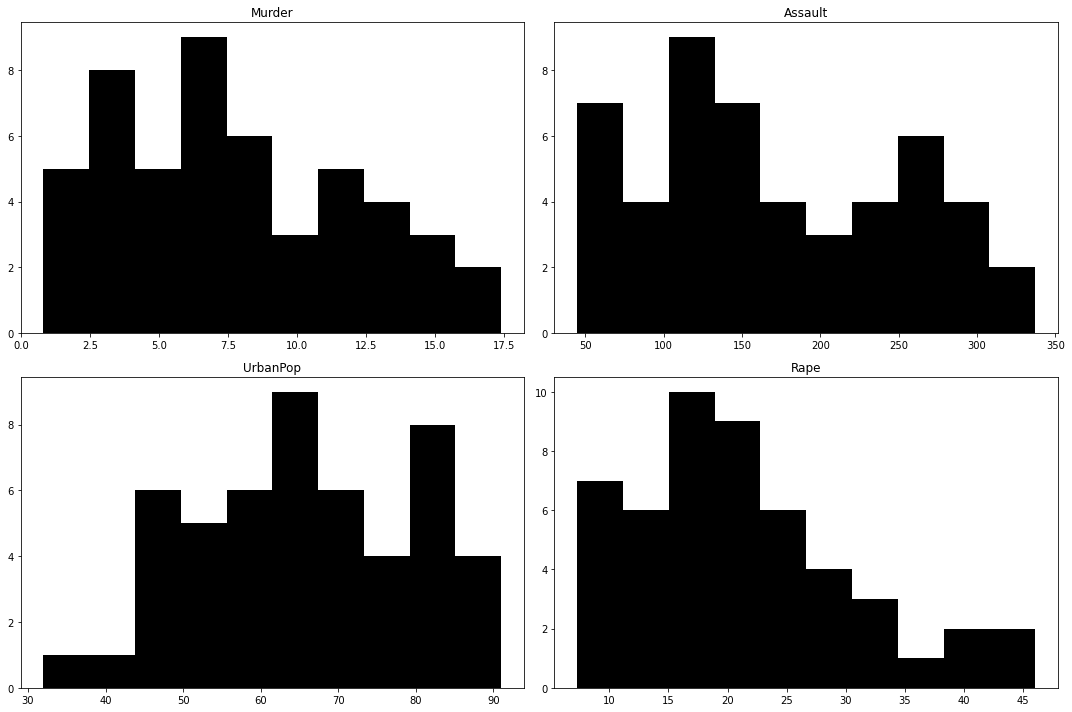

In [7]:
#viewing histograms of the data
histograms = data.hist(color='black',grid=False, figsize=(15,10))
plt.tight_layout()
plt.show()

In [8]:
#view summary stats for each state
frames = [relevant_missing,selected_stats]
summary = pd.concat(frames,axis=1)
summary.rename(columns = {0:"missing"}, inplace = True)
summary.to_csv('summary.csv', index=True) 
summary

,missing,mean,std,min,max
Murder,0,7.788,4.355510,0.8,17.4
Assault,0,170.760,83.337661,45.0,337.0
UrbanPop,0,65.540,14.474763,32.0,91.0
Rape,0,21.232,9.366385,7.3,46.0


<AxesSubplot:>

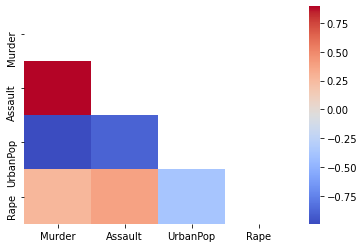

In [9]:
#Correlations - heatmap
corr = data.corr()
corr_df = corr.corr()
mask_ut=np.triu(np.ones(corr_df.shape)).astype(np.bool)
sns.heatmap(corr_df, mask=mask_ut, cmap="coolwarm")

In [10]:
#Correlation matrix
corr

,Murder,Assault,UrbanPop,Rape
Murder,1.000000,0.801873,0.069573,0.563579
Assault,0.801873,1.000000,0.258872,0.665241
UrbanPop,0.069573,0.258872,1.000000,0.411341
Rape,0.563579,0.665241,0.411341,1.000000


The correlation heatmap and correlation matrix show that assault and murder are the most strongly correlated features. 
The correlation matrix shows that urban population is least correlated with the different types of arrests. 

**PCA DIMENSION REDUCTION**

In [11]:
#standardising the data so that feature importance is not swamped due to absolute numbers
df = data.copy()
X = StandardScaler().fit_transform(df.values)

#create pca
pca = PCA(n_components = 3)

#principal components
pc = pca.fit_transform(X)

#creating dataframe 
pca_df = pd.DataFrame(pc, index=df.index)
pca_df.head()

,0,1,2
City,,,
Alabama,0.985566,1.133392,-0.444269
Alaska,1.950138,1.073213,2.040003
Arizona,1.763164,-0.745957,0.054781
Arkansas,-0.141420,1.119797,0.114574
California,2.523980,-1.542934,0.598557


In [23]:
UsA = pd.read_csv('UsArrests.csv')
labels = data.columns

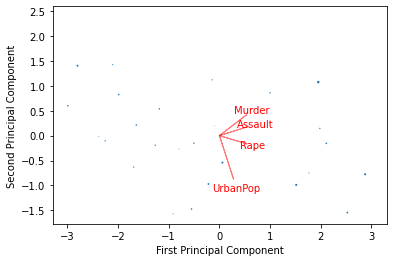

In [25]:
#Plotting biplot


plt.scatter(pc[:, 0], pc[:, 1],  pc[:, 2])

for i, label in enumerate(labels):
    plt.arrow(0, 0, pca.components_[0, i], pca.components_[1, i], color='red', alpha=0.5)
    plt.text(pca.components_[0, i] * 1.2, pca.components_[1, i] * 1.2, label, color='red', ha='center', va='center')
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()

In [27]:
# Feature importance
pd.set_option('display.float_format', lambda x: '%.3f' % x) #change precision to see more decimal places
labels =corr_df.columns

pc1 = abs( pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.536,0.418
1,Assault,0.583,0.188
2,UrbanPop,0.278,0.873
3,Rape,0.543,0.167


In [26]:
#Code for biplot
def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = states[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

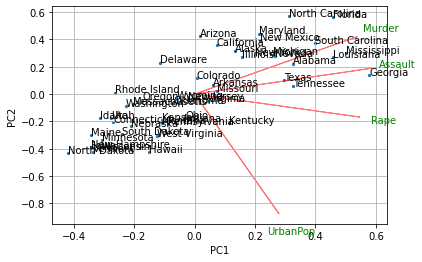

In [28]:
#Biplot

biplot(X[:,0:2],np.transpose(pca.components_[0:2, :]),list(labels),list(states))
plt.show()

This biplot seems to suggest that each feature that make up the arrests are having equal weighting, with the urban population having less of an impact in PC1.
This is confirmed by the feature importance table, which shows that PC1 has equal weighting for each of the three types of arrests, and PC2 giving the most importance to urban population

Text(0.5, 1.0, 'Cumulative Explained Variance')

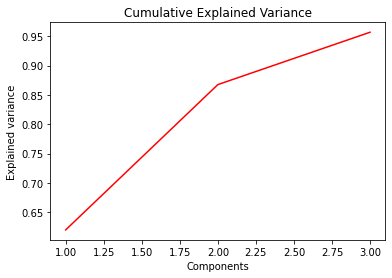

In [29]:
# Cumulative variance plot
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red')
plt.title("Cumulative Explained Variance")

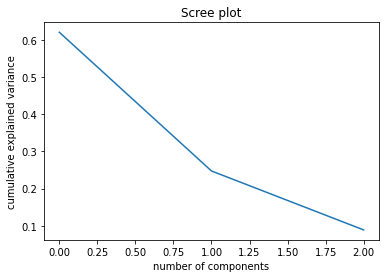

In [30]:
# Scree plot
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Scree plot")
plt.show()

The cumulative variance plot suggest that 2 variables is used to explain 85% of the variance and all three variables are used to explain 95% of the variance.

**AGGLOMERATIVE CLUSTERING**

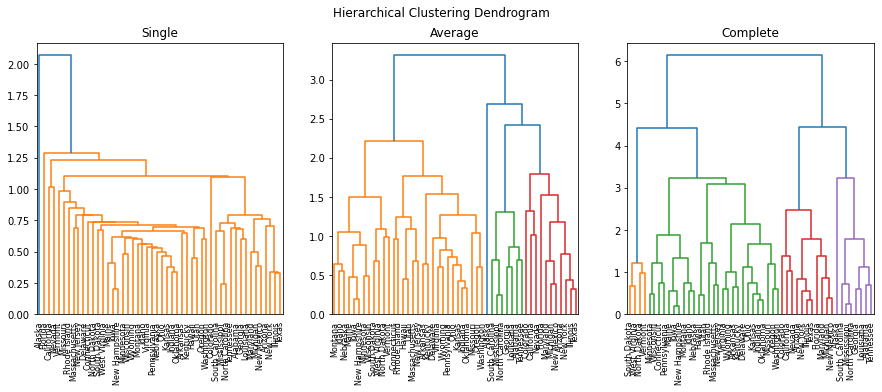

In [31]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pca_df)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,5))
fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Single")
dendrogram(linkage(pca_df, method='single'), labels=states, ax=ax1) #change method: eg. single, average, complete...
ax2.set_title("Average")
dendrogram(linkage(pca_df, method='average'), labels=states, ax=ax2)
ax3.set_title("Complete")
dendrogram(linkage(pca_df, method='complete'), labels=states, ax=ax3)
plt.show()

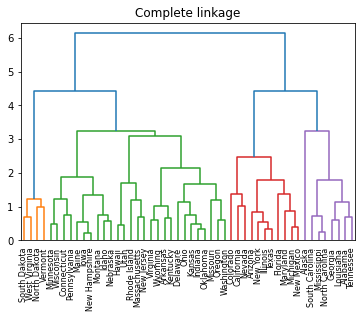

In [32]:
plt.title("Complete linkage")
dendrogram(linkage(pca_df, method='complete'), labels=states)
plt.show()

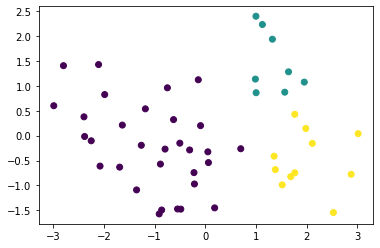

In [33]:
state_cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete')
state_cluster.fit_predict(pc)
ax = plt.scatter(pc[:,0],pc[:,1], c=state_cluster.labels_)
ax

In [34]:
UsA['cluster-label'] = state_cluster.fit_predict(pc)
Cluster1 = UsA.loc[UsA['cluster-label']==0].City.to_numpy()
Cluster2 = UsA.loc[UsA['cluster-label']==1].City.to_numpy()
Cluster3 = UsA.loc[UsA['cluster-label']==2].City.to_numpy()

In [35]:
print("Cluster 1: {}\n\n".format(Cluster1))
print("Cluster 2: {}\n\n".format(Cluster2))
print("Cluster 3: {}\n\n".format(Cluster3))

Cluster 1: ['Arkansas' 'Connecticut' 'Delaware' 'Hawaii' 'Idaho' 'Indiana' 'Iowa'
 'Kansas' 'Kentucky' 'Maine' 'Massachusetts' 'Minnesota' 'Missouri'
 'Montana' 'Nebraska' 'New Hampshire' 'New Jersey' 'North Dakota' 'Ohio'
 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island' 'South Dakota' 'Utah'
 'Vermont' 'Virginia' 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming']


Cluster 2: ['Alabama' 'Alaska' 'Georgia' 'Louisiana' 'Mississippi' 'North Carolina'
 'South Carolina' 'Tennessee']


Cluster 3: ['Arizona' 'California' 'Colorado' 'Florida' 'Illinois' 'Maryland'
 'Michigan' 'Nevada' 'New Mexico' 'New York' 'Texas']




**KEAMNS CLUSTERING**

Text(0, 0.5, 'Dim 1')

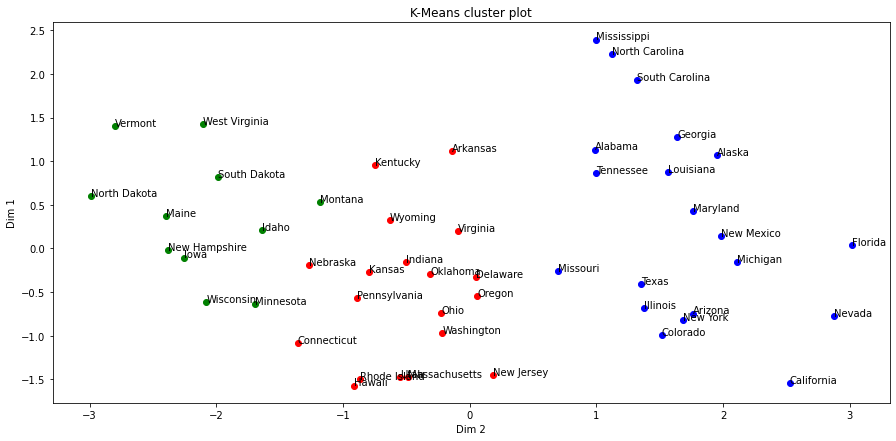

In [36]:
from sklearn.cluster import KMeans

# We extract the first two components
x = pc[:,0]
y = pc[:,1]

# Fit k-means
k=3
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots(figsize=(15,7))
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = states[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")

In [37]:
# Groups - translate to readable names
clusters = pd.DataFrame()

group0_indices = np.argwhere(cluster_labels==0).transpose()[0]
group1_indices = np.argwhere(cluster_labels==1).transpose()[0]
group2_indices = np.argwhere(cluster_labels==2).transpose()[0]

group0 = np.array(states)[group0_indices]
group1 = np.array(states)[group1_indices]
group2 = np.array(states)[group2_indices]


print("Cluster 1: {}\n\n".format(group0))
print("Cluster 2: {}\n\n".format(group1))
print("Cluster 3: {}\n\n".format(group2))

Cluster 1: ['Arkansas' 'Connecticut' 'Delaware' 'Hawaii' 'Indiana' 'Kansas'
 'Kentucky' 'Massachusetts' 'Nebraska' 'New Jersey' 'Ohio' 'Oklahoma'
 'Oregon' 'Pennsylvania' 'Rhode Island' 'Utah' 'Virginia' 'Washington'
 'Wyoming']


Cluster 2: ['Alabama' 'Alaska' 'Arizona' 'California' 'Colorado' 'Florida' 'Georgia'
 'Illinois' 'Louisiana' 'Maryland' 'Michigan' 'Mississippi' 'Missouri'
 'Nevada' 'New Mexico' 'New York' 'North Carolina' 'South Carolina'
 'Tennessee' 'Texas']


Cluster 3: ['Idaho' 'Iowa' 'Maine' 'Minnesota' 'Montana' 'New Hampshire'
 'North Dakota' 'South Dakota' 'Vermont' 'West Virginia' 'Wisconsin']




**COMPARISONS OF CLUSTERING**

Venn diagram for Cluster 1 and Group 1


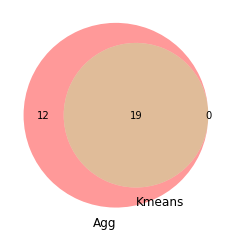

Venn diagram for Cluster 2 and Group 1


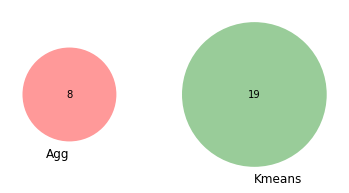

Venn diagram for Cluster 3 and Group 1


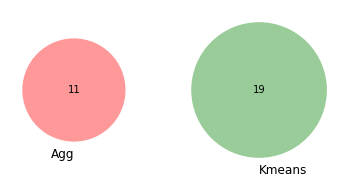

Venn diagram for Cluster 1 and Group 2


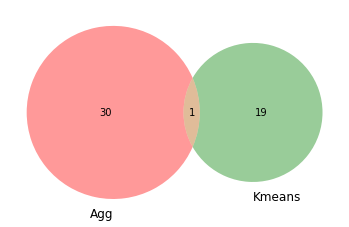

Venn diagram for Cluster 2 and Group 2


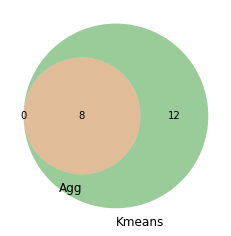

Venn diagram for Cluster 3 and Group 2


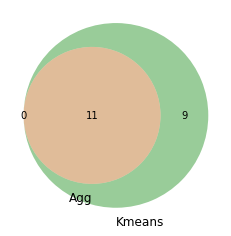

Venn diagram for Cluster 1 and Group 3


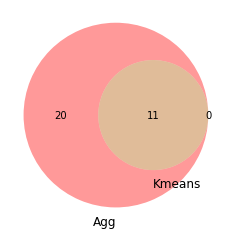

Venn diagram for Cluster 2 and Group 3


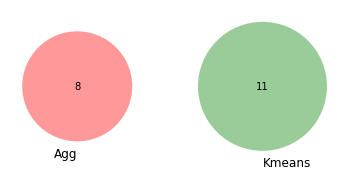

Venn diagram for Cluster 3 and Group 3


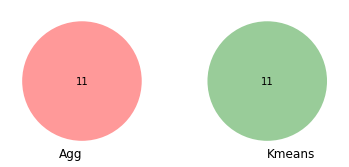

In [38]:
groups = [[group0,'Group 1'],[group1,'Group 2'],[group2,'Group 3']]
clusters = [[Cluster1,'Cluster 1'],[Cluster2,'Cluster 2'],[Cluster3,'Cluster 3']]

for group in groups:
    for cluster in clusters:
        venn2([set(cluster[0]), set(group[0])],set_labels=['Agg','Kmeans'])
        print(f'Venn diagram for {cluster[1]} and {group[1]}')
        plt.show()

It appears from the venn diagram comparisons that cluster 1 (agglomerative clustering) and group 1 (KMeans clustering) have good overlap and all of the states within group 1 and are also in cluster 1, but cluster 1 also contains states not in group 1. The remaining 11 states in cluster 1 are in group 3 of the KMeans cluster. 

It appears that cluster 2 and group 2 have reasonably good overlap, but there is better overlap with cluster 3 and group 2. 

In conclusion it appears cluster 2 and 3 from the agglomerative clustering model are similar to group 2 from the KMeans clustering. Groups 3 and 1 from KMeans clustering are similar to cluster 1 from the agglomerative clustering group. 

